In [1]:
import os, random, sys, math, gc
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

2025-06-26 07:41:31.201589: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750923691.228251    9838 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750923691.236252    9838 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
EMBED_DIM        = 128
USER_MLP_UNITS   = [128, 64]
ITEM_MLP_UNITS   = [128, 64]
BATCH_SIZE       = 1024
EPOCHS           = 150
TOP_K_LIST       = [5, 10, 20]
NEG_RATIO        = 4
LEARNING_RATE    = 1e-4
DROPOUT_RATE     = 0.3
SEED             = 42
MIN_INTERACTIONS = 5
TEST_NEG_SAMPLES = 500

In [3]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(it, **k): return it


In [4]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(it, **k): return it

# GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

2025-06-26 07:41:35.112536: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [5]:
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)
tf.keras.backend.clear_session()

In [6]:
possible = ["ratings.csv", "/kaggle/input/movielens-dataset/ratings.csv"]
ratings_path = next((p for p in possible if os.path.exists(p)), None)
if ratings_path is None:
    sys.exit("[ERROR] 'ratings.csv' not found.")

df = pd.read_csv(ratings_path)
print(f"[INFO] Initial dataset: {len(df):,} interactions")


df.columns = (df.columns.str.strip()
              .str.replace(r'([a-z0-9])([A-Z])', r'\1_\2', regex=True)
              .str.lower().str.replace(r"[\s\-]+", "_", regex=True))


required = {'user_id', 'movie_id', 'rating'}
if not required.issubset(df.columns):
    ren = {}
    for c in df.columns:
        cl = c.lower()
        if 'user'  in cl:                   ren[c] = 'user_id'
        elif 'movie' in cl or 'item' in cl: ren[c] = 'movie_id'
        elif 'rating' in cl:                ren[c] = 'rating'
    df = df.rename(columns=ren)

[INFO] Initial dataset: 105,339 interactions


In [7]:
movies_path = "/kaggle/input/movielens-dataset/movies.csv"
if os.path.exists(movies_path):
    movies_df = pd.read_csv(movies_path)
    movies_df.columns = (movies_df.columns.str.strip()
                         .str.replace(r'([a-z0-9])([A-Z])', r'\1_\2', regex=True)
                         .str.lower().str.replace(r"[\s\-]+", "_", regex=True))
    if 'movieid' in movies_df.columns and 'movie_id' not in movies_df.columns:
        movies_df = movies_df.rename(columns={'movieid': 'movie_id'})
    df = df.merge(movies_df[['movie_id', 'title', 'genres']],
                  on='movie_id', how='left')
    print(f"[INFO] Ratings + metadata: {df.shape}")
else:
    print("[WARNING] movies.csv not found")
    movies_df = pd.DataFrame(columns=['movie_id', 'title', 'genres'])

[INFO] Ratings + metadata: (105339, 6)


In [8]:
user_cnt = df['user_id'].value_counts()
item_cnt = df['movie_id'].value_counts()
valid_users = user_cnt[user_cnt >= MIN_INTERACTIONS].index
valid_items = item_cnt[item_cnt >= MIN_INTERACTIONS].index
df = df[df['user_id'].isin(valid_users) & df['movie_id'].isin(valid_items)]
print(f"[INFO] After filtering: {len(df):,} interactions")


df['label'] = (df['rating'] >= 4).astype(int)
print(f"[INFO] Positive rate: {df['label'].mean():.3f}")


[INFO] After filtering: 94,121 interactions
[INFO] Positive rate: 0.514


In [9]:
uenc = LabelEncoder(); ienc = LabelEncoder()
df['user'] = uenc.fit_transform(df['user_id'])
df['item'] = ienc.fit_transform(df['movie_id'])
num_users, num_items = df['user'].nunique(), df['item'].nunique()
print(f"[INFO] Users: {num_users:,}  •  Items: {num_items:,}")


[INFO] Users: 668  •  Items: 3,855


In [10]:
uenc = LabelEncoder(); ienc = LabelEncoder()
df['user'] = uenc.fit_transform(df['user_id'])
df['item'] = ienc.fit_transform(df['movie_id'])
num_users, num_items = df['user'].nunique(), df['item'].nunique()
print(f"[INFO] Users: {num_users:,}  •  Items: {num_items:,}")


[INFO] Users: 668  •  Items: 3,855


In [11]:


movies_df['genres'] = movies_df['genres'].fillna('(no genres listed)')
movies_df['genre_lst'] = movies_df['genres'].str.split('|')

all_genres = sorted({g for lst in movies_df['genre_lst'] for g in lst
                     if g and g.lower() != '(no genres listed)'})
genre2idx = {g: i for i, g in enumerate(all_genres)}
n_genres = len(genre2idx)
print(f"[INFO] Discovered {n_genres} unique genres")

genre_multi_hot = np.zeros((num_items, n_genres), dtype=np.float32)
movieid2item = dict(zip(df['movie_id'], df['item']))

for _, row in movies_df.iterrows():
    mid = row['movie_id']
    if mid in movieid2item:
        iid = movieid2item[mid]
        for g in row['genre_lst']:
            if g in genre2idx:
                genre_multi_hot[iid, genre2idx[g]] = 1.

print(f"[INFO] Genre matrix shape: {genre_multi_hot.shape}")


[INFO] Discovered 19 unique genres
[INFO] Genre matrix shape: (3855, 19)


In [12]:
def improved_split(dfx, test_ratio=.2, val_ratio=.1):
    sort_col = 'timestamp' if 'timestamp' in dfx.columns else 'rating'
    dfx = dfx.sort_values(sort_col)
    train, val, test = [], [], []
    for u, grp in dfx.groupby('user'):
        n = len(grp); pos = grp[grp['label'] == 1]; neg = grp[grp['label'] == 0]
        if len(pos) >= 3:
            p_test = max(1, int(len(pos)*test_ratio))
            p_val  = max(1, int(len(pos)*val_ratio))
            p_train = len(pos)-p_test-p_val
            if p_train:
                train.append(pos.iloc[:p_train])
                if p_val:  val.append(pos.iloc[p_train:p_train+p_val])
                test.append(pos.iloc[p_train+p_val:])
            if len(neg): train.append(neg)
        else:
            train.append(grp)
    concat = lambda lst: pd.concat(lst, ignore_index=True) if lst else pd.DataFrame()
    return concat(train), concat(val), concat(test)

train_df, val_df, test_df = improved_split(df)
print(f"[INFO] Split  •  Train {len(train_df):,} | Val {len(val_df):,} | Test {len(test_df):,}")

pos_train = train_df[train_df['label'] == 1].groupby('user')['item'].apply(set).to_dict()
pos_val   = val_df[val_df['label'] == 1].groupby('user')['item'].apply(set).to_dict()
pos_test  = test_df[test_df['label'] == 1].groupby('user')['item'].apply(set).to_dict()
all_items = set(range(num_items))

[INFO] Split  •  Train 80,123 | Val 4,583 | Test 9,415


In [13]:
class StableDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df_, neg_ratio, bs):
        self.bs = bs; self.neg_ratio = neg_ratio
        self.train_df = df_
        self.n_items = df_['item'].max()+1
        self.samples = self._prep()
    def _prep(self):
        pos = [(r.user, r.item, 1.) for r in self.train_df[self.train_df.label==1].itertuples()]
        neg = []
        user_pos = train_df[train_df.label==1].groupby('user')['item'].apply(set).to_dict()
        for u,pitems in user_pos.items():
            pool = list(set(range(self.n_items))-pitems)
            num = self.neg_ratio*len(pitems)
            if len(pool)>=num:
                for item in np.random.choice(pool, num, replace=False):
                    neg.append((u,item,0.))
        all_s = pos+neg
        random.shuffle(all_s)
        print(f"[INFO] Samples  pos:{len(pos):,}  neg:{len(neg):,}")
        return all_s
    def __len__(self): return len(self.samples)//self.bs
    def __getitem__(self,i):
        batch = self.samples[i*self.bs:(i+1)*self.bs]
        u = np.array([s[0] for s in batch],dtype=np.int32)
        it= np.array([s[1] for s in batch],dtype=np.int32)
        y = np.array([s[2] for s in batch],dtype=np.float32)
        return {"user_input":u,"item_input":it}, y
    def on_epoch_end(self): random.shuffle(self.samples)

train_gen = StableDataGenerator(train_df, NEG_RATIO, BATCH_SIZE)

[INFO] Samples  pos:34,427  neg:137,708


In [14]:
def create_stable_model(num_users, num_items, embed_dim,
                        user_units, item_units, dropout,
                        genre_mhot):
    tf.keras.backend.clear_session()

    user_in = tf.keras.Input(shape=(),dtype='int32',name='user_input')
    item_in = tf.keras.Input(shape=(),dtype='int32',name='item_input')

    
    user_vec = tf.keras.layers.Flatten()(tf.keras.layers.Embedding(
        num_users, embed_dim, embeddings_initializer='glorot_uniform',
        embeddings_regularizer=tf.keras.regularizers.l2(1e-5))(user_in))

   
    item_id_vec = tf.keras.layers.Flatten()(tf.keras.layers.Embedding(
        num_items, embed_dim, embeddings_initializer='glorot_uniform',
        embeddings_regularizer=tf.keras.regularizers.l2(1e-5))(item_in))
   
    genre_lookup = tf.keras.layers.Embedding(
        input_dim=num_items, output_dim=genre_mhot.shape[1],
        weights=[genre_mhot], trainable=False)(item_in)
    genre_vec = tf.keras.layers.Flatten()(genre_lookup)
    genre_dense = tf.keras.layers.Dense(embed_dim//2, activation='relu')(genre_vec)

    item_base = tf.keras.layers.Concatenate()([item_id_vec, genre_dense])

    def tower(x, units, prefix):
        for i,u in enumerate(units):
            x = tf.keras.layers.Dense(u, activation='relu',
                    kernel_initializer='glorot_uniform',
                    kernel_regularizer=tf.keras.regularizers.l2(1e-5),
                    name=f"{prefix}_dense_{i}")(x)
            x = tf.keras.layers.BatchNormalization(name=f"{prefix}_bn_{i}")(x)
            x = tf.keras.layers.Dropout(dropout,name=f"{prefix}_drop_{i}")(x)
        return x

    user_t = tower(user_vec, user_units, "user")
    item_t = tower(item_base, item_units, "item")

    dot = tf.keras.layers.Dot(axes=1)([user_t,item_t])
    out = tf.keras.layers.Dense(1,activation='sigmoid')(dot)
    
    return tf.keras.Model(inputs=[user_in,item_in], outputs=out)

In [15]:
tf.keras.backend.clear_session()

In [16]:
model = create_stable_model(num_users, num_items, EMBED_DIM,
                            USER_MLP_UNITS, ITEM_MLP_UNITS, DROPOUT_RATE,
                            genre_multi_hot)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ item_input (InputLayer)   │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 19)             │         73,245 │ item_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_input (InputLayer)   │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 128)            │        493,440 │ item_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 19)             │              0 │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 128)            │         85,504 │ user_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 128)            │              0 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │          1,280 │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 128)            │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 192)            │              0 │ flatten_1[0][0],       │
│                           │                        │                │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_dense_0 (Dense)      │ (None, 128)            │         16,512 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item_dense_0 (Dense)      │ (None, 128)            │         24,704 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_bn_0                 │ (None, 128)            │            512 │ user_dense_0[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item_bn_0                 │ (None, 128)            │            512 │ item_dense_0[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_drop_0 (Dropout)     │ (None, 128)            │              0 │ user_bn_0[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item_drop_0 (Dropout)     │ (None, 128)            │              0 │ item_bn_0[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_dense_1 (Dense)      │ (None, 64)             │          8,256 │ user_drop_0[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item_dense_1 (Dense)      │ (None, 64)             │          8,256 │ item_drop_0[0][0]      │
├──────────────────────

 Total params: 712,735 (2.72 MB)

 Trainable params: 638,722 (2.44 MB)

 Non-trainable params: 74,013 (289.11 KB)

In [17]:
def stable_loss(y_true, y_pred):
    y_true = y_true*0.9+0.05
    y_pred = tf.clip_by_value(y_pred,1e-7,1-1e-7)
    return tf.reduce_mean(-(y_true*tf.math.log(y_pred)+(1-y_true)*tf.math.log(1-y_pred)))

opt = tf.keras.optimizers.Adam(LEARNING_RATE)
model.compile(optimizer=opt, loss=stable_loss,
              metrics=['binary_accuracy','precision','recall'])
print(f"[INFO] Model params: {model.count_params():,}")

[INFO] Model params: 712,735


In [18]:
# Compile model
opt = tf.keras.optimizers.Adam(LEARNING_RATE)
model.compile(optimizer=opt, loss=stable_loss,
              metrics=['binary_accuracy', 'precision', 'recall'])
print(f"[INFO] Model params: {model.count_params():,}")

# Define callbacks
cbs = [
    tf.keras.callbacks.EarlyStopping(
        monitor='loss', patience=10, restore_best_weights=True, verbose=1),
    
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
    
    tf.keras.callbacks.LambdaCallback(
        on_epoch_end=lambda e, l: print(
            f"Ep{e+1}  loss {l['loss']:.4f}  acc {l['binary_accuracy']:.3f}  "
            f"prec {l['precision']:.3f}  rec {l['recall']:.3f}")
    )
]

# Train model
print("[INFO] Training...")
hist = model.fit(train_gen, epochs=EPOCHS, callbacks=cbs, verbose=1)


[INFO] Model params: 712,735
[INFO] Training...
Epoch 1/150


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


166/168 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - binary_accuracy: 0.5154 - loss: 0.7677 - precision: 0.2006 - recall: 0.4744Ep1  loss 0.7588  acc 0.517  prec 0.200  rec 0.474
168/168 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - binary_accuracy: 0.5154 - loss: 0.7676 - precision: 0.2006 - recall: 0.4744 - learning_rate: 1.0000e-04
Epoch 2/150
166/168 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - binary_accuracy: 0.5289 - loss: 0.7327 - precision: 0.2056 - recall: 0.4697Ep2  loss 0.7265  acc 0.532  prec 0.205  rec 0.466
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - binary_accuracy: 0.5290 - loss: 0.7326 - precision: 0.2056 - recall: 0.4697 - learning_rate: 1.0000e-04
Epoch 3/150
167/168 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - binary_accuracy: 0.5506 - loss: 0.7086 - precision: 0.2101 - recall: 0.4517Ep3  loss 0.7052  acc 0.556  prec 0.212  rec 0.449
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - binary_accuracy: 0.5507 - loss: 0.7085 - precision: 0.2101 - recall: 0.4516 - learning_rate: 1.0000e-04
Epoch 4/150
166/168 ━

In [19]:
def evaluate(pos_test_dict, model, k_list, neg_samples=500):
    results = {k:{'precision':[],'recall':[],'hit_rate':[],'ndcg':[]} for k in k_list}
    for uid,true_items in tqdm(pos_test_dict.items(),desc="Evaluate"):
        if not true_items: continue
        seen = pos_train.get(uid,set())|pos_val.get(uid,set())
        cand = list(all_items-seen)
        neg = np.random.choice(cand, neg_samples, replace=False) if len(cand)>neg_samples else cand
        items = list(true_items)+list(neg)
        users = np.full(len(items), uid, dtype=np.int32)
        scores = model.predict({"user_input":users,"item_input":np.array(items)},verbose=0).ravel()
        rank = [x for x,_ in sorted(zip(items,scores), key=lambda p:p[1], reverse=True)]
        for k in k_list:
            top = rank[:k]
            hits=[i for i in top if i in true_items]
            prec=len(hits)/k
            rec=len(hits)/len(true_items)
            hr=1 if hits else 0
            dcg=sum(1/np.log2(i+2) for i,it in enumerate(top) if it in true_items)
            idcg=sum(1/np.log2(i+2) for i in range(min(len(true_items),k)))
            ndcg=dcg/idcg if idcg else 0
            for m,v in zip(['precision','recall','hit_rate','ndcg'],
                           [prec,rec,hr,ndcg]):
                results[k][m].append(v)
    return {k:{m:np.mean(v) for m,v in res.items()} for k,res in results.items()}



In [20]:
print("\n" + "="*60 + "\nEVALUATION\n" + "="*60)
if pos_test:
    eval_res = evaluate(pos_test, model, TOP_K_LIST, TEST_NEG_SAMPLES)
    for k in TOP_K_LIST:
        print(f"\nTop-{k}")
        for m in ['precision','recall','hit_rate','ndcg']:
            print(f"{m.title()}@{k}: {eval_res[k][m]:.4f}")
else:
    print("[WARNING] No test data.")

print("\n[INFO] Training complete!")



EVALUATION


Evaluate: 100%|██████████| 666/666 [01:40<00:00,  6.65it/s]


Top-5
Precision@5: 0.2267
Recall@5: 0.1502
Hit_Rate@5: 0.5976
Ndcg@5: 0.2509

Top-10
Precision@10: 0.2068
Recall@10: 0.2492
Hit_Rate@10: 0.7357
Ndcg@10: 0.2729

Top-20
Precision@20: 0.1807
Recall@20: 0.3864
Hit_Rate@20: 0.8378
Ndcg@20: 0.3165

[INFO] Training complete!


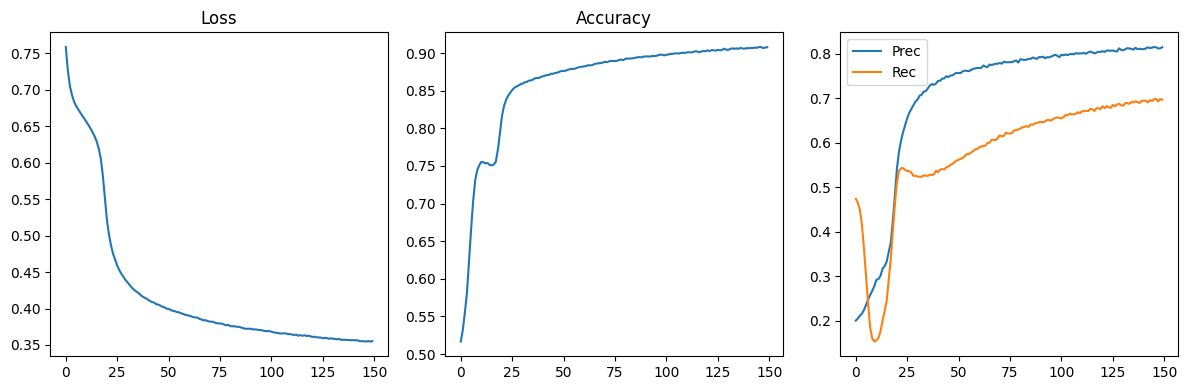

63681

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.plot(hist.history['loss']); plt.title("Loss")
plt.subplot(1,3,2); plt.plot(hist.history['binary_accuracy']); plt.title("Accuracy")
plt.subplot(1,3,3)
if 'precision' in hist.history: plt.plot(hist.history['precision'], label='Prec')
if 'recall'    in hist.history: plt.plot(hist.history['recall'],    label='Rec')
plt.legend(); plt.tight_layout(); plt.show(); gc.collect()

In [22]:
def recommend_movies_for_user(user_id, model, top_k=10):
    
    item_ids = np.arange(num_items)
    user_ids = np.full_like(item_ids, fill_value=user_id)
    scores = model.predict({"user_input": user_ids, "item_input": item_ids}, verbose=0).flatten()

   
    seen = pos_train.get(user_id, set()) | pos_val.get(user_id, set())
    unseen_items = np.array([i for i in item_ids if i not in seen])
    
    
    user_ids_unseen = np.full_like(unseen_items, fill_value=user_id)
    scores_unseen = model.predict({"user_input": user_ids_unseen, "item_input": unseen_items}, verbose=0).flatten()
    
    top_indices = np.argsort(scores_unseen)[-top_k:][::-1]
    top_item_ids = unseen_items[top_indices]
    
    
    inv_item_map = dict(zip(df['item'], df['movie_id']))
    inv_title_map = dict(zip(movies_df['movie_id'], movies_df['title']))
    recommended_titles = [inv_title_map.get(inv_item_map[i], f"Item {i}") for i in top_item_ids]
    
    return recommended_titles


In [23]:

sample_users = random.sample(list(pos_test.keys()), 5)

for uid in sample_users:
    print(f"\nTop recommendations for User {uid}:")
    recs = recommend_movies_for_user(uid, model, top_k=20)
    for i, title in enumerate(recs, 1):
        print(f"{i}. {title}")



Top recommendations for User 525:
1. Meet the Parents (2000)
2. Amistad (1997)
3. Forrest Gump (1994)
4. Seabiscuit (2003)
5. Ghost (1990)
6. Maverick (1994)
7. Pulp Fiction (1994)
8. Schindler's List (1993)
9. American Beauty (1999)
10. Toy Story (1995)
11. Toy Story 2 (1999)
12. Raising Arizona (1987)
13. Godfather, The (1972)
14. Silence of the Lambs, The (1991)
15. Clear and Present Danger (1994)
16. Patriot Games (1992)
17. Erin Brockovich (2000)
18. L.A. Confidential (1997)
19. Fargo (1996)
20. Apollo 13 (1995)

Top recommendations for User 404:
1. Indiana Jones and the Last Crusade (1989)
2. Lord of the Rings: The Two Towers, The (2002)
3. Edward Scissorhands (1990)
4. Green Mile, The (1999)
5. Monty Python's Life of Brian (1979)
6. Taxi Driver (1976)
7. Sixth Sense, The (1999)
8. Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000)
9. Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)
10. Batman Begins (2005)
11. Fargo (1996)
12. Léon: The Professio

In [25]:
model.save("two_tower_model_2.h5")
